<a href="https://colab.research.google.com/github/KarthiK-ctrl-A/BigDataAnalytics/blob/main/HandsOn_SaiKarthikPatri_feb_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-World Data Processing with RNN, LSTM, and GRU in PyTorch


In [1]:
!pip install yfinance

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# Download the AAPL stock data from Yahoo Finance for the last 3 years
ticker = 'AAPL'
df = yf.download(ticker, period='3y', interval='1d')

# Select the 'Close' price for modeling
data = df[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

# Function to create sequences for RNNs
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

seq_length = 30  # Use past 30 days to predict the next day
X, y = create_sequences(data, seq_length)

# Reshape X to match PyTorch format (batch_size, sequence_length, features)
X = X.view(X.shape[0], seq_length, 1)

[*********************100%***********************]  1 of 1 completed
<ipython-input-2-3fa2b5becc56>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)


## Define RNN, LSTM, and GRU Models

In [3]:

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out


## Training the Models and Recording Loss

In [4]:

def train_model(model, X, y, epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y.view(-1, 1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

    return losses

# Initialize models
rnn_model = RNNModel(input_size=1, hidden_size=64, output_size=1)
lstm_model = LSTMModel(input_size=1, hidden_size=64, output_size=1)
gru_model = GRUModel(input_size=1, hidden_size=64, output_size=1)

# Train models and record loss
rnn_losses = train_model(rnn_model, X, y)
lstm_losses = train_model(lstm_model, X, y)
gru_losses = train_model(gru_model, X, y)


Epoch 0, Loss: 0.2564
Epoch 10, Loss: 0.1313
Epoch 20, Loss: 0.0319
Epoch 30, Loss: 0.0119
Epoch 40, Loss: 0.0055
Epoch 50, Loss: 0.0043
Epoch 60, Loss: 0.0040
Epoch 70, Loss: 0.0040
Epoch 80, Loss: 0.0039
Epoch 90, Loss: 0.0038
Epoch 0, Loss: 0.2379
Epoch 10, Loss: 0.1923
Epoch 20, Loss: 0.1402
Epoch 30, Loss: 0.0325
Epoch 40, Loss: 0.0106
Epoch 50, Loss: 0.0097
Epoch 60, Loss: 0.0080
Epoch 70, Loss: 0.0075
Epoch 80, Loss: 0.0071
Epoch 90, Loss: 0.0068
Epoch 0, Loss: 0.3043
Epoch 10, Loss: 0.1840
Epoch 20, Loss: 0.1169
Epoch 30, Loss: 0.0451
Epoch 40, Loss: 0.0125
Epoch 50, Loss: 0.0063
Epoch 60, Loss: 0.0067
Epoch 70, Loss: 0.0047
Epoch 80, Loss: 0.0045
Epoch 90, Loss: 0.0044


## Visualizing the Training Loss

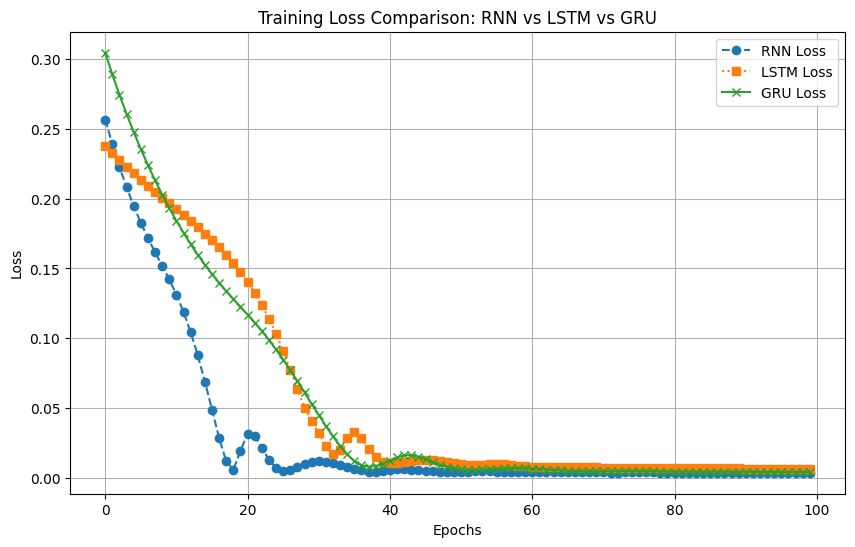

In [5]:

# Plot Training Loss Curves
plt.figure(figsize=(10,6))
plt.plot(rnn_losses, label='RNN Loss', linestyle='dashed', marker='o')
plt.plot(lstm_losses, label='LSTM Loss', linestyle='dotted', marker='s')
plt.plot(gru_losses, label='GRU Loss', linestyle='solid', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison: RNN vs LSTM vs GRU')
plt.legend()
plt.grid(True)
plt.show()


## Testing the Models on New Data

In [6]:

def predict(model, input_seq):
    model.eval()
    input_seq = torch.tensor(input_seq, dtype=torch.float32).view(1, seq_length, 1)
    with torch.no_grad():
        prediction = model(input_seq)
    return scaler.inverse_transform(prediction.numpy().reshape(-1, 1))[0][0]

# Example Test Case (Predict Next Day's Closing Price)
test_seq = data[-seq_length:].reshape(-1, 1)  # Use the last 30 days
RNNPrediction = predict(rnn_model, test_seq)
LSTMPrediction = predict(lstm_model, test_seq)
GRUPrediction = predict(gru_model, test_seq)
print("RNN Prediction:", RNNPrediction)
print("LSTM Prediction:", LSTMPrediction)
print("GRU Prediction:", GRUPrediction)


RNN Prediction: 233.821
LSTM Prediction: 233.50426
GRU Prediction: 234.45041


In [7]:
!pip install transformers


In [8]:
from transformers import pipeline

# Initialize the large language model (LLM) for text generation
explainer = pipeline("text-generation", model="HuggingFaceH4/zephyr-7b-alpha", device=0, torch_dtype="auto")  # Example LLM model

# Define the prompts based on your model predictions
prompts = {
    "RNN": f"Explain why the RNN model predicted {RNNPrediction} for the Apple stock price based on the past 30 days.",
    "LSTM": f"Explain why the LSTM model predicted {LSTMPrediction} for the Apple stock price based on the past 30 days.",
    "GRU": f"Explain why the GRU model predicted {GRUPrediction} for the Apple stock price based on the past 30 days.",
}

# Fetch explanations for each prompt
for model_name, prompt in prompts.items():
    explanation = explainer(prompt, max_length=100)
    print(f"{model_name} Prediction Explanation: {explanation[0]['generated_text']}\n")

# Additional Explainability Prompts (Sample)
additional_prompts = {
    "RNN_LSTM_Comparison": "Explain why LSTM performs better than RNN for long-term dependencies in time-series data.",
    "LSTM_GRU_Comparison": "What are the main differences between LSTM and GRU models when predicting stock prices?",
}

# Fetch explanations for model comparisons
for prompt_name, prompt in additional_prompts.items():
    explanation = explainer(prompt, max_length=100)
    print(f"{prompt_name} Explanation: {explanation[0]['generated_text']}\n")


config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


RNN Prediction Explanation: Explain why the RNN model predicted 233.8209991455078 for the Apple stock price based on the past 30 days.

Generate according to: We have trained a Recurrent Neural Network (RNN) model to predict the Apple stock price based on the past 30 days.

The RNN model predicted 233.82099914550

LSTM Prediction Explanation: Explain why the LSTM model predicted 233.50425720214844 for the Apple stock price based on the past 30 days.

Generate according to: The LSTM model predicted 233.50425720214844 for the Apple stock price based on the past 30 days.
The LSTM model predicted 119.999

GRU Prediction Explanation: Explain why the GRU model predicted 234.45040893554688 for the Apple stock price based on the past 30 days.
Generate according to: The GRU model is a type of recurrent neural network that is specifically designed to handle time series data. It is a gated recurrent unit that can learn long-term dependencies in the data. The GRU model is particularly useful for p